Image dataset already unzipped.
Using device: cuda
Loading model...
Model loaded successfully
Starting baseline evaluation...
Loading dataset from /kaggle/input/dataset-vqa/vqa_dataset_gemini_final.csv
Dataset loaded successfully with 19497 samples
Columns: ['path', 'generated_question', 'generated_answer']
Total dataset size: 19497

Processing sample size: 3000 (3000 samples)
Running inference on 3000 samples...


100%|██████████| 3000/3000 [04:33<00:00, 10.96it/s]


Evaluating predictions for sample size 3000...

Results for sample size 3000:
exact_match_accuracy: 0.6640
relaxed_accuracy: 0.6820
word_overlap: 0.6762
Time taken: 273.79 seconds
Results for sample size 3000 saved to /kaggle/working/results/blip_baseline_results_3000.csv

Processing sample size: 7000 (7000 samples)
Running inference on 7000 samples...


100%|██████████| 7000/7000 [10:22<00:00, 11.24it/s]


Evaluating predictions for sample size 7000...

Results for sample size 7000:
exact_match_accuracy: 0.6648
relaxed_accuracy: 0.6863
word_overlap: 0.6778
Time taken: 622.73 seconds
Results for sample size 7000 saved to /kaggle/working/results/blip_baseline_results_7000.csv

Processing sample size: 10000 (10000 samples)
Running inference on 10000 samples...


100%|██████████| 10000/10000 [14:44<00:00, 11.31it/s]


Evaluating predictions for sample size 10000...

Results for sample size 10000:
exact_match_accuracy: 0.6651
relaxed_accuracy: 0.6869
word_overlap: 0.6781
Time taken: 884.13 seconds
Results for sample size 10000 saved to /kaggle/working/results/blip_baseline_results_10000.csv

Processing sample size: full (19497 samples)
Running inference on 19497 samples...


100%|██████████| 19497/19497 [28:57<00:00, 11.22it/s]


Evaluating predictions for sample size full...

Results for sample size full:
exact_match_accuracy: 0.6603
relaxed_accuracy: 0.6834
word_overlap: 0.6744
Time taken: 1737.95 seconds
Results for sample size full saved to /kaggle/working/results/blip_baseline_results_full.csv

All metrics saved to /kaggle/working/results/blip_baseline_all_metrics.csv
All results saved to /kaggle/working/results/blip_baseline_all_results.csv
Metrics plot saved to /kaggle/working/results/blip_metrics_by_sample_size.png

Total evaluation time: 3519.08 seconds
Progressive baseline evaluation completed!


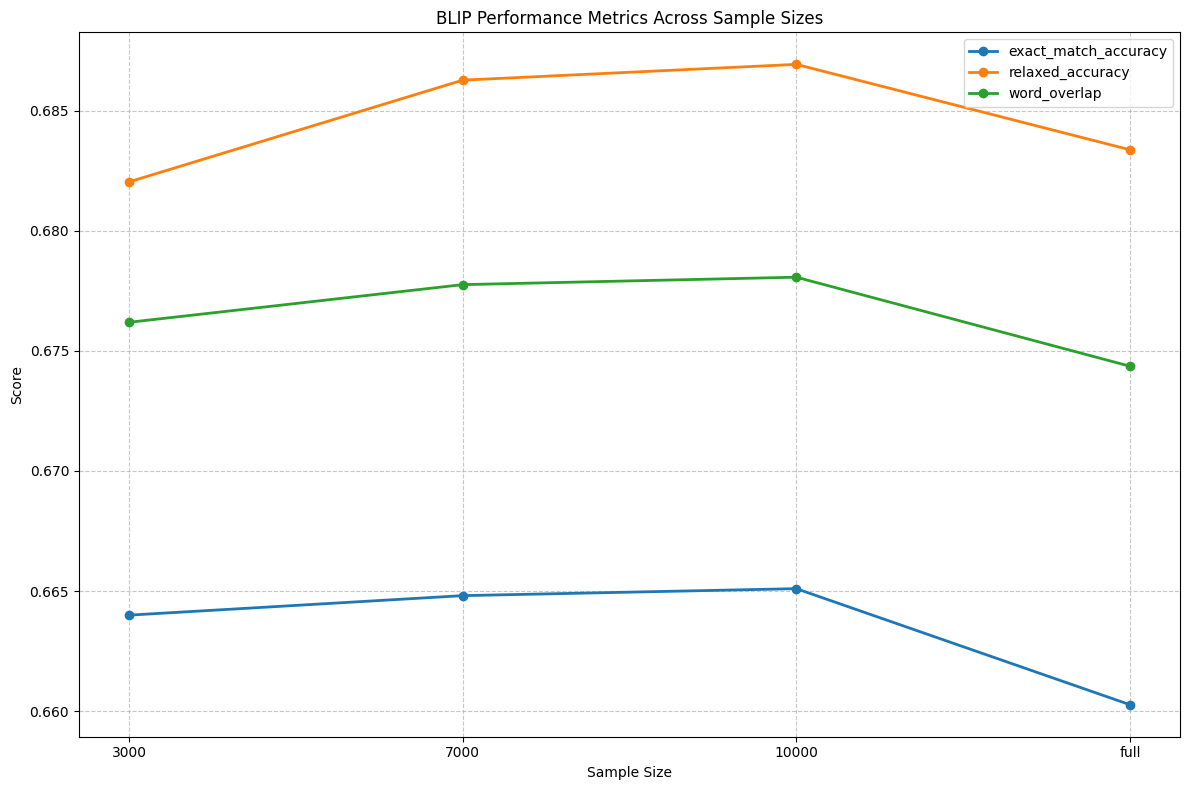

In [3]:
import os
import torch
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from transformers import BlipProcessor, BlipForQuestionAnswering
from sklearn.metrics import accuracy_score, f1_score
import zipfile

zip_path = "/kaggle/input/dataset-vqa/req-images.zip"
unzip_path = "/kaggle/input/dataset-vqa/req-images"

if not os.path.exists(unzip_path):
    print("Unzipping image dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(unzip_path)
    print("Unzipping completed.")
else:
    print("Image dataset already unzipped.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

os.makedirs("/kaggle/working/results", exist_ok=True)

print("Loading model...")
model_name = "Salesforce/blip-vqa-base"
processor = BlipProcessor.from_pretrained(model_name)
model = BlipForQuestionAnswering.from_pretrained(model_name)
model.to(device)
print("Model loaded successfully")

def load_kaggle_vqa_dataset():
    try:
        csv_path = "/kaggle/input/dataset-vqa/vqa_dataset_gemini_final.csv"
        print(f"Loading dataset from {csv_path}")
        df = pd.read_csv(csv_path)
        print(f"Dataset loaded successfully with {len(df)} samples")
        print(f"Columns: {df.columns.tolist()}")
        return df
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

def run_inference(image_path, question):
    try:
        image = Image.open(image_path).convert('RGB')
        inputs = processor(image, question, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model.generate(**inputs, max_new_tokens=20)
        generated_text = processor.decode(outputs[0], skip_special_tokens=True).strip()
        return generated_text
    except Exception as e:
        print(f"Error during inference for image {image_path}: {e}")
        return ""

def evaluate_predictions(predictions, ground_truths):
    exact_matches = [pred.lower() == gt.lower() for pred, gt in zip(predictions, ground_truths)]
    accuracy = sum(exact_matches) / len(exact_matches)
    relaxed_matches = [gt.lower() in pred.lower() or pred.lower() in gt.lower() 
                      for pred, gt in zip(predictions, ground_truths)]
    relaxed_accuracy = sum(relaxed_matches) / len(relaxed_matches)
    
    def word_overlap_score(pred, gt):
        if not pred or not gt:
            return 0.0
        pred_words = set(pred.lower().split())
        gt_words = set(gt.lower().split())
        if not gt_words:
            return 0.0
        return len(pred_words.intersection(gt_words)) / len(gt_words)
    
    word_overlap_scores = [word_overlap_score(pred, gt) for pred, gt in zip(predictions, ground_truths)]
    avg_word_overlap = sum(word_overlap_scores) / len(word_overlap_scores)
    
    metrics = {
        "exact_match_accuracy": accuracy,
        "relaxed_accuracy": relaxed_accuracy,
        "word_overlap": avg_word_overlap
    }
    
    return metrics

def run_progressive_baseline_evaluation(sample_sizes=[3000, 7000, 'full']):
    start_time_total = time.time()
    full_df = load_kaggle_vqa_dataset()
    if full_df is None:
        print("Failed to load dataset. Exiting.")
        return
    
    total_size = len(full_df)
    print(f"Total dataset size: {total_size}")
    actual_sample_sizes = [size if size != 'full' else total_size for size in sample_sizes]
    actual_sample_sizes = sorted([min(size, total_size) for size in actual_sample_sizes if isinstance(size, (int, float)) or size == total_size])
    all_metrics = {}
    all_sample_times = {}
    cumulative_results = pd.DataFrame(columns=['image_id', 'question', 'ground_truth', 'prediction', 'sample_size'])
    
    for sample_size in actual_sample_sizes:
        sample_name = 'full' if sample_size == total_size else str(sample_size)
        print(f"\n{'='*50}")
        print(f"Processing sample size: {sample_name} ({sample_size} samples)")
        print(f"{'='*50}")
        
        start_time = time.time()
        if sample_size < total_size:
            current_df = full_df.sample(sample_size, random_state=42)
        else:
            current_df = full_df
        
        predictions = []
        ground_truths = []
        image_ids = []
        questions = []
        
        print(f"Running inference on {sample_size} samples...")
        for idx, row in tqdm(current_df.iterrows(), total=len(current_df)):
            image_path = row['path']
            question = row['generated_question']
            ground_truth = row['generated_answer']
            if not isinstance(question, str) or not isinstance(ground_truth, str):
                continue
            if question.strip().lower() == ground_truth.strip().lower():
                continue
            if not image_path.startswith('/kaggle'):
                image_path = os.path.join('/kaggle/input/dataset-vqa/req-images/', image_path)
            prediction = run_inference(image_path, question)
            predictions.append(prediction)
            ground_truths.append(ground_truth)
            image_ids.append(os.path.basename(image_path))
            questions.append(question)
        
        print(f"Evaluating predictions for sample size {sample_name}...")
        metrics = evaluate_predictions(predictions, ground_truths)
        all_metrics[sample_size] = metrics
        elapsed_time = time.time() - start_time
        all_sample_times[sample_size] = elapsed_time
        
        print(f"\nResults for sample size {sample_name}:")
        for metric_name, metric_value in metrics.items():
            print(f"{metric_name}: {metric_value:.4f}")
        print(f"Time taken: {elapsed_time:.2f} seconds")
        
        results_df = pd.DataFrame({
            'image_id': image_ids,
            'question': questions,
            'ground_truth': ground_truths,
            'prediction': predictions,
            'sample_size': [sample_name] * len(predictions)
        })
        
        cumulative_results = pd.concat([cumulative_results, results_df], ignore_index=True)
        
        sample_results_path = f"/kaggle/working/results/blip_baseline_results_{sample_name}.csv"
        results_df.to_csv(sample_results_path, index=False)
        print(f"Results for sample size {sample_name} saved to {sample_results_path}")
    
    metrics_df = pd.DataFrame([all_metrics[size] for size in actual_sample_sizes], 
                             index=[str(size) if size != total_size else 'full' for size in actual_sample_sizes])
    metrics_df['sample_size'] = [str(size) if size != total_size else 'full' for size in actual_sample_sizes]
    metrics_df['time_seconds'] = [all_sample_times[size] for size in actual_sample_sizes]
    
    metrics_path = "/kaggle/working/results/blip_baseline_all_metrics.csv"
    metrics_df.to_csv(metrics_path)
    print(f"\nAll metrics saved to {metrics_path}")
    
    all_results_path = "/kaggle/working/results/blip_baseline_all_results.csv"
    cumulative_results.to_csv(all_results_path, index=False)
    print(f"All results saved to {all_results_path}")
    
    plot_metrics(all_metrics, actual_sample_sizes, total_size)
    
    total_time = time.time() - start_time_total
    print(f"\nTotal evaluation time: {total_time:.2f} seconds")
    
    return all_metrics, cumulative_results

def plot_metrics(all_metrics, sample_sizes, total_size):
    plt.figure(figsize=(12, 8))
    metric_names = list(next(iter(all_metrics.values())).keys())
    x_labels = [str(size) if size != total_size else 'full' for size in sample_sizes]
    
    for i, metric in enumerate(metric_names):
        metric_values = [all_metrics[size][metric] for size in sample_sizes]
        plt.plot(x_labels, metric_values, marker='o', linewidth=2, label=metric)
    
    plt.xlabel('Sample Size')
    plt.ylabel('Score')
    plt.title('BLIP Performance Metrics Across Sample Sizes')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    
    plot_path = "/kaggle/working/results/blip_metrics_by_sample_size.png"
    plt.savefig(plot_path)
    print(f"Metrics plot saved to {plot_path}")

if __name__ == "__main__":
    print("Starting baseline evaluation...")
    sample_sizes = [3000, 7000, 10000, 'full']
    all_metrics, all_results = run_progressive_baseline_evaluation(sample_sizes=sample_sizes)
    print("Progressive baseline evaluation completed!")
